# Electrical Load Classification with Open Set Recognition - Demo code and dataset
- This is the work of Daniel Istvan Nemeth. The code and dataset is provided as a demo for our publication.
- The dataset and the code provided here should not be used without explicit permission from the authors. 

In [1]:
!tar -xvf demodataset.tar.gz
!pip3 install libmr

dataset-demo/
dataset-demo/ledspotlight_halved_7x10_d8/
dataset-demo/ledspotlight_halved_7x10_d8/ledspotlight_0095.txt
dataset-demo/ledspotlight_halved_7x10_d8/ledspotlight_0015.txt
dataset-demo/ledspotlight_halved_7x10_d8/ledspotlight_0026.txt
dataset-demo/ledspotlight_halved_7x10_d8/ledspotlight_0025.txt
dataset-demo/ledspotlight_halved_7x10_d8/ledspotlight_0050.txt
dataset-demo/ledspotlight_halved_7x10_d8/ledspotlight_0002.txt
dataset-demo/ledspotlight_halved_7x10_d8/ledspotlight_0005.txt
dataset-demo/ledspotlight_halved_7x10_d8/ledspotlight_0085.txt
dataset-demo/ledspotlight_halved_7x10_d8/ledspotlight_0030.txt
dataset-demo/ledspotlight_halved_7x10_d8/ledspotlight_0016.txt
dataset-demo/ledspotlight_halved_7x10_d8/ledspotlight_0031.txt
dataset-demo/ledspotlight_halved_7x10_d8/ledspotlight_0007.txt
dataset-demo/ledspotlight_halved_7x10_d8/ledspotlight_0003.txt
dataset-demo/ledspotlight_halved_7x10_d8/ledspotlight_0028.txt
dataset-demo/ledspotlight_halved_7x10_d8/ledspotlight_0084.txt

## Loading the dataset

In [2]:
import os
import numpy as np
from datetime import datetime
import math
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

class Dataset:
    def __init__(self):
        self.devicenames = ["ipad10W", "usb5V1A", "usbapple5V1A", "batterycharger4A", "batterycharger800mA", "fan",
                            "hairdryer", "ledbulb", "ledspotlight", "incandescentbulb", "irlamp", "laptop", "monitor",
                            "solderingiron"]
        self.devicemap = [["ipad10W", "usb5V1A", "usbapple5V1A"], ["batterycharger4A"], ["batterycharger800mA"],
                          ["fan"], ["hairdryer"], ["ledbulb"], ["ledspotlight"], ["incandescentbulb", "irlamp"],
                          ["laptop"], ["monitor"], ["solderingiron"]]
        self.folderprefix = "./dataset-demo/"
        self.NUMSAMPLES = 100
        TEST_ORIG = (5, 20, 16, 14, (10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75), "original_14x20_d16")
        TEST_HALVED = (6, 10, 8, 7, (15, 25, 35, 45, 55, 65, 75), "halved_7x10_d8")
        TEST_FOUR = (8, 8, 4, 4, (15, 35, 55, 75), "four_4x8_d4")
        self.PROFILES = [TEST_ORIG, TEST_HALVED, TEST_FOUR]
        self.dataset_poweronly = {}
        self.keys = []
        for fpath in self.devicemap:
            self.keys.append("-".join(fpath))

    def load_dataset(self, profile_idx):
        profile = self.PROFILES[profile_idx]
        self.profileidx = profile_idx
        dimx = profile[1]
        dimy = profile[3]
        for i in self.devicenames:
            self.dataset_poweronly[i] = []

        for devicename in self.devicenames:
            onlyfiles = [f for f in os.listdir(self.folderprefix + devicename + "_" + profile[5]) if
                         os.path.isfile(
                             os.path.join(self.folderprefix + devicename + "_" + profile[5], f)) and f.endswith(
                             ".txt")]
            onlyfiles.sort()
            
            findex = 0
            for fpathind in range(0, min(len(onlyfiles), self.NUMSAMPLES)):
                fpath = onlyfiles[fpathind]
                f2 = open(self.folderprefix + devicename + "_" + profile[5] + "/" + fpath, "r")
                text = f2.read()
                f2.close()
                # txt = text.split("\n")
                data = text.split("\n")
                avg1 = [[0 for x in range(dimx)] for y in range(dimy)]
                flag = False
                for i in range(dimy):
                    j = 0
                    for dat in data[i].split("\t"):
                        if len(dat) > 0:
                            avg1[i][j] = float(dat)
                            if math.isnan(avg1[i][j]):
                                flag = True
                            j += 1
                avg = np.mean(avg1)
                if not flag:
                    self.dataset_poweronly[devicename].append(np.expand_dims(avg1, axis=2))

    def get_train_test_openset(self, num_train, num_test, omittedindex):
        X_train = []
        X_test = []
        y_train = []
        y_test = []
        cntr = 0
        labelcntr = 0

        X_unknown = []
        for fnamelist in self.devicemap:
            if cntr == omittedindex:
                for fname in fnamelist:
                    allnames = []
                    alldatas = []
                    for i in range(len(self.dataset_poweronly[fname])):
                        allnames.append(cntr)
                        alldatas.append(self.dataset_poweronly[fname][i])
                    X_unknown.append(np.array(alldatas))
            else:
                num_train_added = 0
                num_test_added = 0
                for fname in fnamelist:
                    allnames = []
                    alldatas = []                    
                    for i in range(len(self.dataset_poweronly[fname])):
                        allnames.append(cntr)
                        alldatas.append(self.dataset_poweronly[fname][i])
                    if fname == fnamelist[-1]:
                        xtr, xte, ytr, yte = train_test_split(alldatas, allnames,
                                                              train_size=num_train - num_train_added,
                                                              test_size=num_test - num_test_added)
                        X_train += xtr
                        X_test += xte
                        y_train += [labelcntr] * len(xtr)
                        y_test += [labelcntr] * len(xte)
                    else:
                        num_train_added += int(num_train / len(fnamelist))
                        num_test_added += int(num_test / len(fnamelist))
                        xtr, xte, ytr, yte = train_test_split(alldatas, allnames,
                                                              train_size=int(num_train / len(fnamelist)),
                                                              test_size=int(num_test / len(fnamelist)))
                        X_train += xtr
                        X_test += xte
                        y_train += [labelcntr] * len(xtr)
                        y_test += [labelcntr] * len(xte)
                labelcntr += 1
            cntr += 1

        npXtrain = np.array(X_train)
        npXtest = np.array(X_test)
        npYtrain = to_categorical(np.array(y_train))
        npYtest = to_categorical(np.array(y_test))
        return npXtrain, npXtest, npYtrain, npYtest, X_train, X_test, y_train, y_test, X_unknown

    def get_keyset(self):
        return self.keys

    def get_testprofile(self):
        return self.PROFILES[self.profileidx]


## Data visualization

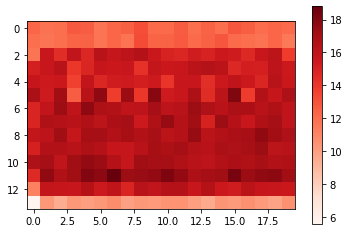

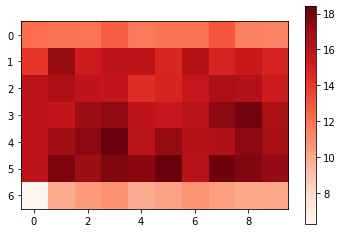

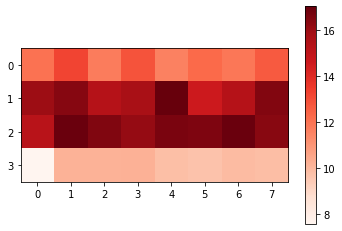

In [12]:
import matplotlib.pyplot as plt
exampledataset = Dataset()
exampledataset.load_dataset(0) #TEST_ORIG profile

exampledata = np.squeeze(exampledataset.dataset_poweronly["ledbulb"][10])
plt.imshow(exampledata, cmap='Reds', interpolation='nearest')
plt.colorbar()
plt.show()
exampledataset = Dataset()
exampledataset.load_dataset(1) #TEST_HALVED profile
exampledata = np.squeeze(exampledataset.dataset_poweronly["ledbulb"][10])
plt.imshow(exampledata, cmap='Reds', interpolation='nearest')
plt.colorbar()
plt.show()
exampledataset = Dataset()
exampledataset.load_dataset(2) #TEST_FOUR profile
exampledata = np.squeeze(exampledataset.dataset_poweronly["ledbulb"][10])
plt.imshow(exampledata, cmap='Reds', interpolation='nearest')
plt.colorbar()
plt.show()

## Running the modified OpenMax-based Open Set recognition

In [4]:
import numpy as np
from datetime import datetime
import math
import sys

import tensorflow as tf
from tensorflow.keras import layers, models
import libmr

import time as time_  # make sure we don't override time
def millis():
    return int(round(time_.time() * 1000))

desired_width = 240

np.set_printoptions(linewidth=desired_width)

now = datetime.now()
datestring = now.strftime("%Y_%m_%d_%H_%M_%S")
NUM_TRAIN = 65
NUM_RUNS = 1


WEIBULL_TAIL_RANGE = [0, NUM_TRAIN]

REJECT_THRESHOLD = 0.33
TOP_N = 2
OPENMAX_MULTIPLIER = 0.05
start_ms = millis()

def elapsed():
    return "[ " + str(millis() -start_ms) + " ]"

def calc_mav_for_train_samples(npX):
    dimy = npX.shape[1]
    dimx = npX.shape[2]
    dataset_svm_means = np.array([0] * 10)
    for i in range(npX.shape[0]):
        avg1 = npX[i, :, :, 0]
        avg = np.mean(avg1)
        std = np.std(avg1)
        stsorok = np.std(avg1, axis=1)
        stoszlopok = np.std(avg1, axis=0)
        soravg = np.mean(stsorok)
        oszlopavg = np.mean(stoszlopok)
        sorstd = np.std(stsorok)
        oszlopstd = np.std(stoszlopok)
        balfel = (avg1[0][0] + avg1[0][1] + avg1[1][0] + avg1[1][1]) / (avg * 4)
        balle = (avg1[dimy - 1][0] + avg1[dimy - 1][1] + avg1[dimy - 2][0] + avg1[dimy - 2][1]) / (avg * 4)
        jobbfel = (avg1[0][dimx - 1] + avg1[0][dimx - 2] + avg1[1][dimx - 1] + avg1[1][dimx - 2]) / (avg * 4)
        jobble = (avg1[dimy - 1][dimx - 1] + avg1[dimy - 1][dimx - 2] + avg1[dimy - 2][dimx - 1] + avg1[dimy - 2][dimx - 2]) / (avg * 4)
        dataset_svm_means = np.add(dataset_svm_means, np.array(
            [avg, std, soravg, sorstd, oszlopavg, oszlopstd, balfel, balle, jobbfel, jobble]))
    return dataset_svm_means/npX.shape[0]

def calc_features_mean(avg1, dimy, dimx, mean):
    avg1 = np.squeeze(avg1)

    avg = np.mean(avg1)
    std = np.std(avg1)
    stsorok = np.std(avg1, axis=1)
    stoszlopok = np.std(avg1, axis=0)
    soravg = np.mean(stsorok)
    oszlopavg = np.mean(stoszlopok)
    sorstd = np.std(stsorok)
    oszlopstd = np.std(stoszlopok)
    balfel = (avg1[0][0] + avg1[0][1] + avg1[1][0] + avg1[1][1]) / (avg * 4)
    balle = (avg1[dimy - 1][0] + avg1[dimy - 1][1] + avg1[dimy - 2][0] + avg1[dimy - 2][1]) / (avg * 4)
    jobbfel = (avg1[0][dimx - 1] + avg1[0][dimx - 2] + avg1[1][dimx - 1] + avg1[1][dimx - 2]) / (avg * 4)
    jobble = (avg1[dimy - 1][dimx - 1] + avg1[dimy - 1][dimx - 2] + avg1[dimy - 2][dimx - 1] +
                avg1[dimy - 2][dimx - 2]) / (avg * 4)
    avg = avg
    return np.array([avg/mean[0], std/mean[1], soravg/mean[2], sorstd/mean[3], oszlopavg/mean[4], oszlopstd/mean[5], balfel/mean[6], balle/mean[7], jobbfel/mean[8], jobble/mean[9]])


def run_openset(profileidx, openclassindexes, num_runs, dispname):
    print(elapsed(), "Loading dataset...")
    dataset = Dataset()
    print(elapsed(), "Running openset function...")
    dataset.load_dataset(profileidx)
    print(elapsed(), f'Profile: {dataset.PROFILES[profileidx][5]}')
    keys = dataset.get_keyset()
    numunknown = len(dataset.devicemap[openclassindexes])
    numknown = len(keys)-1
    keys_vertical = keys.copy()
    keys_vertical.remove(keys[openclassindexes])
    keys_vertical += ["UNKNOWN("+x+")" for x in dataset.devicemap[openclassindexes]]
    keys_horizontal_closed = keys.copy()
    keys_horizontal_closed.remove(keys[openclassindexes])
    keys_horizontal_open = keys.copy()
    keys_horizontal_open.remove(keys[openclassindexes])
    keys_horizontal_open += ["UNKNOWN(" + keys[openclassindexes] + ")"]


    npXtrain, npXtest, npYtrain, npYtest, X_train, X_test, y_train, y_test, Xunknown = \
        dataset.get_train_test_openset(NUM_TRAIN, dataset.NUMSAMPLES - NUM_TRAIN, openclassindexes)
    meanvector = calc_mav_for_train_samples(npXtrain)
    print(elapsed(), "Mean of SVM featurevectors: ", meanvector)
    confmatrix = np.array([[0 for x in range(numknown)] for y in range(numknown + numunknown)])
    openconfmatrix = np.array([[0 for x in range(numknown + 1)] for y in range(numknown + numunknown)])


    print(elapsed(), "Training CNN model...")

    LAYERS = -2

    verbose, epochs, batch_size = 0, 140, 200
    model = models.Sequential()
    model.add(layers.Conv2D(30, (3, 3), activation='relu', input_shape=(npXtrain.shape[1], npXtrain.shape[2], 1),
                            padding='same'))
    model.add(layers.Conv2D(40, (3, 3), activation='softmax'))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(20, activation='relu'))

    model.add(layers.Dense(npYtrain.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    if openclassindexes == 0:
        model.summary()
    model.fit(npXtrain, npYtrain, epochs=epochs, verbose=verbose, batch_size=batch_size)

    print(elapsed(), "SoftMAX model trained, computing AVs")
    mfeat = {}
    feat = {}
    for i in range(numknown):
        feat[i] = []
    for i in range(len(npYtrain)):
        true_label = y_train[i]
        avc = calc_features_mean(npXtrain[i:i+1,:,:,:], npXtrain.shape[1], npXtrain.shape[2], meanvector)
        feat[true_label].append(avc)
    print(elapsed(), "Computing MAVs and weibull")    
    
    featlens = []
    for i in range(numknown):
        featlens.append(len(feat[i]))
        feat[i] = np.array(feat[i])
        mfeat[i] = np.mean(feat[i], axis=0)
        print("MAV for " + keys_vertical[i].ljust(30) + ": ", mfeat[i])
    dist_from_respmean = {}
    for i in range(numknown):
        dist_from_respmean[i] = []
    for i in range(numknown):
        n = feat[i].shape[0]
        for j in range(n):
            penult = feat[i][j]
            dist_from_respmean[i].append(np.sqrt(np.sum(np.square(np.subtract(penult, mfeat[i])))))
    for i in range(numknown):
        dist_from_respmean[i] = sorted(dist_from_respmean[i])
        if len(dist_from_respmean) == 0:
            print("Error! dist_from_respmean empty for class", i)
    weib_models = []
    for i in range(numknown):
        meta = libmr.MR()
        meta.fit_low(dist_from_respmean[i][WEIBULL_TAIL_RANGE[0]:WEIBULL_TAIL_RANGE[1]],
                        WEIBULL_TAIL_RANGE[1 ] -WEIBULL_TAIL_RANGE[0])
        weib_models.append(meta)

    total_classified = 0
    correctly_classified_open = 0
    correctly_classified_soft = 0
    correctly_classified_open_known = 0
    correctly_classified_open_unknown = 0
    print(elapsed(), "Evaluating performance for known samples...")
    for i in range(npXtest.shape[0]): # For known test samples
        input_mat = npXtest[i:i + 1, :, :, :]
        true_class = y_test[i]
        act_vector = calc_features_mean(input_mat, npXtrain.shape[1], npXtrain.shape[2], meanvector)
        softmax_out = model.predict(input_mat, verbose=0)[0]
        top_predictions = softmax_out.argsort()[-TOP_N:][::-1]
        alpha_weight = []
        dist_from_means = []
        for q in top_predictions:
            alpha_weight.append(0)
            dist_from_means.append(np.sqrt(np.sum(np.square(np.subtract(act_vector, mfeat[q])))))
        ds = np.argsort(dist_from_means)
        for q in range(TOP_N):
            place = ds[q]
            alpha_weight[place] = (TOP_N - q) / float(TOP_N)
        wscore = []
        ws2 = []
        for q in range(TOP_N):
            ws2.append(weib_models[top_predictions[q]].w_score(dist_from_means[q]))
            wscore.append(alpha_weight[q] * ws2[-1])
        wscore = np.array(wscore)
        revised_act = []
        filtered_softmax = []
        for q in range(TOP_N):
            filtered_softmax.append(softmax_out[top_predictions[q]])
            revised_act.append(filtered_softmax[-1] * wscore[q])
        filtered_softmax = np.array(filtered_softmax)
        revised_act.append(OPENMAX_MULTIPLIER * np.sum(np.multiply(filtered_softmax, 1 - wscore)))
        revised_act = np.asarray(revised_act)
        openmax_val = np.exp(revised_act) / np.sum(np.exp(revised_act))
        top_predictions = np.append(top_predictions, numknown)
        openmax_pred = top_predictions[np.argmax(openmax_val)]
        softmax_pred = np.argmax(softmax_out)
        if np.max(openmax_val) < REJECT_THRESHOLD and openmax_pred != numknown:
            print("Rejected based on threshold (" + str(openmax_pred) + "," + str(
                np.max(openmax_val)) + "<" + str(
                REJECT_THRESHOLD) + " ( correct: " + str(true_class) + ") (INCORRECTLY)")
            openmax_pred = numknown
        confmatrix[true_class][softmax_pred] += 1
        openconfmatrix[true_class][openmax_pred] += 1
        total_classified += 1
        if true_class == softmax_pred:
            correctly_classified_soft += 1
        if true_class == openmax_pred:
            correctly_classified_open += 1
            correctly_classified_open_known += 1
    print(elapsed(), "Evaluating performance for unknown samples...")
    numunknown_total = 0
    for cnum in range(numunknown): # for the unknown classes
        numunknown_total += len(Xunknown[cnum])
        for i in range(len(Xunknown[cnum])):
            debug_txt = ""
            input_mat = Xunknown[cnum][i:i + 1, :, :, :]
            true_class = numknown + cnum
            act_vector = calc_features_mean(input_mat, npXtrain.shape[1], npXtrain.shape[2], meanvector)
            softmax_out = model.predict(input_mat, verbose=0)[0]
            top_predictions = softmax_out.argsort()[-TOP_N:][::-1]
            alpha_weight = []
            dist_from_means = []
            for q in top_predictions:
                alpha_weight.append(0)
                dist_from_means.append(np.sqrt(np.sum(np.square(np.subtract(act_vector, mfeat[q])))))
            ds = np.argsort(dist_from_means)
            for q in range(TOP_N):
                place = ds[q]
                alpha_weight[place] = (TOP_N - q) / float(TOP_N)
            wscore = []
            ws2 = []
            for q in range(TOP_N):
                ws2.append(weib_models[top_predictions[q]].w_score(dist_from_means[q]))
                wscore.append(alpha_weight[q] * ws2[-1])
            wscore = np.array(wscore)
            revised_act = []
            filtered_softmax = []
            for q in range(TOP_N):
                filtered_softmax.append(softmax_out[top_predictions[q]])
                revised_act.append(filtered_softmax[-1] * wscore[q])
            filtered_softmax = np.array(filtered_softmax)
            revised_act.append \
                (OPENMAX_MULTIPLIER * np.sum(np.multiply(filtered_softmax, 1 - wscore)))
            revised_act = np.asarray(revised_act)
            openmax_val = np.exp(revised_act) / np.sum(np.exp(revised_act))
            top_predictions = np.append(top_predictions, numknown)
            openmax_pred = top_predictions[np.argmax(openmax_val)]
            softmax_pred = np.argmax(softmax_out)
            if np.max(openmax_val) < REJECT_THRESHOLD and openmax_pred != numknown:
                print("Rejected based on threshold (" + str(openmax_pred) + "," + str(
                    np.max(openmax_val)) + "<" + str(
                    REJECT_THRESHOLD) + " ( correct: " + str(true_class) + ") (CORRECTLY)")
                openmax_pred = numknown
            confmatrix[true_class][softmax_pred] += 1
            openconfmatrix[true_class][openmax_pred] += 1
            total_classified += 1
            if softmax_pred == numknown:
                correctly_classified_soft += 1
            if numknown == openmax_pred:
                correctly_classified_open += 1
                correctly_classified_open_unknown += 1

    accu_soft = correctly_classified_soft /total_classified
    accu_open = correctly_classified_open /total_classified

    accu_open_known = correctly_classified_open_known/npXtest.shape[0]
    accu_open_unknown = correctly_classified_open_unknown/numunknown_total

    strout = "----------------------------------------------------------------\n=== Results: ===\n" + dispname + "\n" + dataset.get_testprofile()[5] + "\nDimensions: <" + str(
        dataset.get_testprofile()[1]) + "x" + str(dataset.get_testprofile()[3]) + ">\n"
    strout += "=== Closed (CNN with SoftMax) ===\n"
    strout += "Accuracy: \t" + str(round(100*accu_soft,2)) + "%\n"
    strout += "\t" + "\t".join(keys_horizontal_closed) + "\n"
    cm = confmatrix
    for i in range(numknown + numunknown):
        strout += keys_vertical[i].ljust(30) + " "
        for j in range(numknown):
            cm[i][j] = round(cm[i][j], 5)
            strout += str(round(cm[i][j], 2)).rjust(6) + " "
        strout += "\n"
    strout += "=== Open Set recognition (CNN with modified OpenMax) ===\n"
    strout += "Total   Accuracy: \t" + str(round(100*accu_open,2)) + "%\n"
    strout += "KNOWN   Accuracy: \t" + str(round(100*accu_open_known,2)) + "%\n"
    strout += "UNKNOWN Accuracy: \t" + str(round(100*accu_open_unknown,2)) + "%\n"
    cm = openconfmatrix
    strout += "\t" + "\t".join(keys_horizontal_open) + "\n"
    bads = ""
    for i in range(numknown +numunknown):
        strout += keys_vertical[i].ljust(30) + " "
        for j in range(numknown + 1):
            cm[i][j] = round(cm[i][j], 5)
            strout += str(round(cm[i][j], 2)).rjust(3) + " "
        strout += "\n"
        if i >= numknown:
            bads += keys_vertical[i].ljust(30) + " -> "
            for j in range(numknown):
                if cm[i][j] > 0:
                    bads += keys_horizontal_open[j] + "(" + str(round(cm[i][j], 2)).rjust(3) + "), "
            bads += "\n"
    errormat = ""
    cm_err = confmatrix
    for q in range(numunknown):
        qq = numknown + q
        errormat += keys_vertical[qq].ljust(30)
        for j in range(numknown):
            if openclassindexes == j:
                errormat += "  - "
            errormat += " "+str(round(cm_err[qq][j], 2)).rjust(3)
        if openclassindexes == numknown:
            errormat += "  - "
        errormat += "\n"
    print(strout)
    print("=== Misclassification in case of OpenSet: ===")
    print(bads)
    print("\n----------------------------------------------------------------\n")

    return confmatrix, openconfmatrix, accu_open_known, accu_open_unknown, bads, errormat


datas = Dataset()
for i in [0, 1, 2]:
    confmats = []
    openconfmats = []
    accus_known = []
    accus_unknown = []
    bads_total = ""
    errormatrix = "-\t"+"\t".join(datas.get_keyset())+"\n"
    for open2 in range(len(datas.get_keyset())):
        print(datas.PROFILES[i][5], "-", open2+1, "/", len(datas.get_keyset()), "UNKNOWN Class:", datas.get_keyset()[open2])
        cm0, ocm0, accu_known, accu_unknown, bads, errormat = run_openset(i, open2, NUM_RUNS, "Unknown: " + datas.get_keyset()[open2])
        bads_total += bads
        openconfmats.append(ocm0)
        confmats.append(cm0)
        accus_known.append(accu_known)
        accus_unknown.append(accu_unknown)
        errormatrix += errormat
    summary_string = "UNKNOWN ".ljust(30)+"Accu known " + "Accu unknown\n"
    for open2 in range(len(datas.get_keyset())):
        summary_string += datas.get_keyset()[open2].rjust(30) + " " + (str(round(100*accus_known[open2],2)) + "%").ljust(7) + " " + (str(round(100*accus_unknown[open2],2))+"%").ljust(7) + "\n"
    print("========== Summary for profile " + datas.PROFILES[i][5] + ": ==========")
    print("=== Accuracy rates: ===")
    print(summary_string)
    print("=== Misclassifications for OpenSet: ===")
    print(bads_total)
    print("=== Closed CNN (SoftMax) misclassification matrix (for unknown samples): ===")
    print(errormatrix + "\n")
    print("==========\n")


original_14x20_d16 - 1 / 11 UNKNOWN Class: ipad10W-usb5V1A-usbapple5V1A
[ 5 ] Loading dataset...
[ 5 ] Running openset function...
[ 356 ] Profile: original_14x20_d16
[ 489 ] Mean of SVM featurevectors:  [71.17729962 18.01595447  4.47353754  5.29480418 17.44540121  2.81119497  1.11592988  0.55691133  1.21575393  0.56737417]
[ 490 ] Training CNN model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 20, 30)        300       
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 18, 40)        10840     
                                                                 
 flatten_2 (Flatten)         (None, 8640)              0         
                                                                 
 dropout_2 (Dropout)         (None, 8640)              0         
                            